In [1]:
import os, sys
from pathlib import Path
import urllib.request

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import nltk
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
tv_show = "avatar"

In [26]:
nltk.download('punkt')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")
embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

!gunzip {str(embeddings_path)}

[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
downloading embeddings...
/Users/andy/Documents/projects/w266-final/analysis/../embeddings/newscrawl.300d.W.pos.vectors already exists -- do you wish to overwrite (y or n)? ^C


In [27]:
dialog_datas = []

for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_data["episode"] = filename.split(".")[0]
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas).dropna().reset_index(drop=True)

In [28]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      10356
utterance    10356
episode      10356
dtype: int64


,speaker,utterance,episode
0,Sokka,"So, what kind of trouble is Katara in?",220
1,Aang,"I don't know. In my vision, I just knew she ne...",220
2,Sokka,It would be nice if your Avatar powers could b...,220
3,Sokka,What is that?!,220
4,Sokka,Need a ride?,220


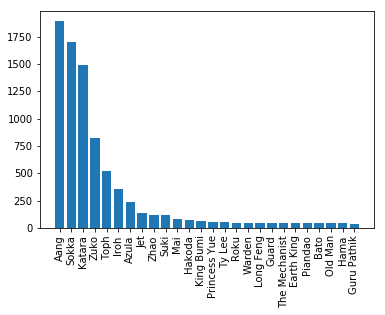

In [29]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values
plt.bar(x, y)
plt.xticks(x, x, rotation="vertical")
plt.show()

In [30]:
num_major_characters = 6
major_characters = set(x[:num_major_characters])

In [31]:
major_characters

{'Aang', 'Iroh', 'Katara', 'Sokka', 'Toph', 'Zuko'}

In [32]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters)]
print(major_dialog_data.count())

speaker      6784
utterance    6784
episode      6784
dtype: int64


In [33]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

utterances = list(map(lambda utter: tokenizer.tokenize(utter.lower()), major_dialog_data.utterance))
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

(array([5.066e+03, 1.399e+03, 2.370e+02, 4.400e+01, 2.200e+01, 4.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 1.000e+00]),
 array([  1.,  17.,  33.,  49.,  65.,  81.,  97., 113., 129., 145., 161.]),
 <a list of 10 Patch objects>)

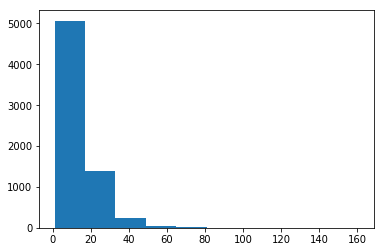

In [34]:
plt.hist([len(words) for words in utterances])

In [35]:
bags = np.zeros((major_dialog_data.utterance.count(), embeddings.vector_size))

for i, utterance in enumerate(utterances):
    bag = np.sum(embeddings.word_vec(word) for word in utterance if word in embeddings.vocab)
    if type(bag) == np.ndarray:
        bags[i, :] = bag

train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
train_x = bags[0:train_cut]
train_y = labels[0:train_cut]
test_x = bags[train_cut:]
test_y = labels[train_cut:]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(5767, 300) (5767,) (1017, 300) (1017,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


In [36]:
model = LogisticRegression(multi_class="ovr")
model.fit(train_x, train_y)
model.score(test_x, test_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.32055063913470994